
Text Classification (Sentiment Analysis) Using Bayes Rule
==============


## Goal

Your goal in this part of assigment is to implement a Naive Bayes Multinomial classifier using  bag of words model for the classification of text (movie reviews) into different categories..

**Note** Please note that you are allowed to use only those libraries which we have discussed in the class, i.e. numpy, scipy, pandas.

Once you have build and test the model on the provided dataset. You will use the learned techniques to compete in a [Kaggle](https://www.kaggle.com/c/word2vec-nlp-tutorial) competition and report your final score and leaderboard ranking to get full credit.


In [1]:
!pip install nose

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 2.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
'/content/drive/MyDrive/data'



'/content/drive/MyDrive/data'

In [4]:
import numpy as np

In [5]:
%pylab inline
import scipy.stats
from collections import defaultdict

Populating the interactive namespace from numpy and matplotlib


In [6]:
import re
import bs4

def parse_string(string):
    """"
        Parse the input string and tokenize it using regular expressisons:
        First clean the string such that it does not have any punctuation or number, it must only have a-z and A-Z.
        Please note that while doing this, the spaces much not get disturbed, but in case of multiple spaces convert
        them to one space.
        Then convert the string to lower case and return its words as a list of strings.

        Example:
        --------
        Input :  computer scien_tist-s are,,,  the  rock__stars of tomorrow_ <cool>  ????
        Output:  ['computer', 'scientists', 'are', 'the', 'rockstars', 'of', 'tomorrow']

        Parameters:
        ----------
        string: string to be parsed...
        re: regular expression to be used for the tokenization.

        Returns:
        ---------
        list of tokens extracted from the string...
    """

    # YOUR CODE HERE

    cleaned = re.sub(r'[^a-zA-Z\s]', '', string)
    cleaned = re.sub(r'\s+', ' ', cleaned)

    cleaned = cleaned.lower()

    tokens = cleaned.split()

    # raise NotImplementedError()

    return tokens



In [7]:
def parse_file(filename): # Parse a given file
    """"
        Parameters:
        ----------
        filename: name of text file to be read


        Returns:
        ---------
        read file as raw string (with \n, \t, \r, etc included)
    """
    # YOUR CODE HERE

    string = ""

    with open(filename, 'r') as file:
      string = file.read()

    return string

In [8]:
import numpy as np

def files_to_strings(X):

    """
        Read an array (or list) of files where each file content is read in a string...
        Input:
        -------
        X an array (or list) of file names

        Returns:
        --------
        X as a numpy array with each row containing a read string from the file...
    """

    # YOUR CODE HERE
    string_list = []

    for filename in X:
      with open(filename, 'r') as file:
        string = file.read()
        string_list.append(string)

    return np.array(string_list)

In [9]:
from nose.tools import assert_equal, assert_list_equal

assert_list_equal(parse_string("computer scien_tist-s are,,,  the  rock__stars of tomorrow_ <cool>  ????"),
        [u'computer', u'scientists', u'are', u'the', u'rockstars', u'of', u'tomorrow', u'cool'], "Incorrect cleanning")


strings = files_to_strings(np.array(["/content/drive/MyDrive/data/imdb1/neg/cv000_29416.txt", "/content/drive/MyDrive/data/imdb1/pos/cv000_29590.txt"]))
with open("/content/drive/MyDrive/data/imdb1/neg/cv000_29416.txt") as f:
    text = f.read()

assert_equal(strings[0], text, "At first index should be text of first file")
assert_equal(strings.shape, (2,), "Shape must be (2,) for two files in list")

In [10]:
from collections import Counter
import numpy as np

class NaiveBayes:
    ''' Implements the Naive Bayes For Text Classification... '''
    def __init__(self, classes):
        self.classes = classes
        self.prior_probs = {}
        self.words_count_class_wise = {}
        self.words_prob_class_wise = {}

    # Receives combined string tokens for each class, uses Counter to assign word count.
    def addExample(self, tokens, class_label):
        token_count_dict = Counter(tokens)
        self.words_count_class_wise[class_label] = token_count_dict

    def train(self, X, Y):
        combined_string_class_wise = {class_label: "" for class_label in self.classes}
        self.prior_probs = {class_label: 0 for class_label in self.classes}
        self.words_count_class_wise = {class_label: {} for class_label in self.classes}
        self.words_prob_class_wise = {class_label: {} for class_label in self.classes}

        # Count the examples and combine texts by class
        nexamples = len(X)
        for i in range(nexamples):
            text = X[i][0]
            label = Y[i]
            combined_string_class_wise[label] += " " + text
            self.prior_probs[label] += 1

        # Convert prior counts to probabilities
        for class_label in self.classes:
            self.prior_probs[class_label] = np.log(self.prior_probs[class_label] / nexamples)  # Using log for stability

        # Build word count dictionary per class and overall vocabulary
        total_count_each_word = {}
        for class_label in self.classes:
            tokens = parse_string(combined_string_class_wise[class_label])
            self.addExample(tokens, class_label)

            for word, count in self.words_count_class_wise[class_label].items():
                if word in total_count_each_word:
                    total_count_each_word[word] += count
                else:
                    total_count_each_word[word] = count

        vocab_size = len(total_count_each_word)  # Total vocabulary size for smoothing

        # Apply Laplace smoothing and calculate word probabilities
        for class_label in self.classes:
            total_words = sum(list(self.words_count_class_wise[class_label].values()))
            for word, _ in total_count_each_word.items():
                word_count = self.words_count_class_wise[class_label].get(word, 0)
                # Apply Laplace smoothing and use log to prevent underflow
                self.words_prob_class_wise[class_label][word] = np.log((word_count + 1) / (total_words + vocab_size))

    def test(self, X):
        ''' Test the trained classifiers on the given set of examples '''
        nexamples = X.shape[0]
        pclass = []

        for i in range(nexamples):
            text = X[i][0]
            text_tokens = parse_string(text)

            log_likelihoods = {class_label: self.prior_probs[class_label] for class_label in self.classes}
            for token in text_tokens:
                for class_label in self.classes:
                    if token in self.words_prob_class_wise[class_label]:
                        log_prob = self.words_prob_class_wise[class_label][token]
                    else:
                        total_words = sum(list(self.words_count_class_wise[class_label].values()))
                        vocab_size = len(self.words_prob_class_wise[class_label])
                        log_prob = np.log(1 / (total_words + vocab_size))  # Log Laplace smoothing for unseen words

                    log_likelihoods[class_label] += log_prob

            # Find the class with the highest log-likelihood
            best_class = max(log_likelihoods, key=log_likelihoods.get)
            pclass.append(best_class)

        return np.array(pclass)

    def predict(self, x):
        ''' Predict the label of given input example... '''
        x_array = np.array([x], dtype=object)  # Wrap in an array of shape (1, )
        predicted_class = self.test(x_array)[0]  # Call test and get the first result

        return predicted_class

In [12]:
import pandas as pd
import numpy as np
import sys
sys.path.append('/content/drive/My Drive')
import tools as t


In [13]:
tdir= "/content/drive/MyDrive/data/imdb1/" # training dir...
#load data, get list of files for each class...
posfiles=t.get_files(tdir+'/pos','*',withpath=True)
negfiles=t.get_files(tdir+'/neg','*',withpath=True)

In [14]:
#generate training and testing data...
plabels=['pos']*len(posfiles)
nlabels=['neg']*len(posfiles)
labels=np.concatenate((plabels,nlabels)) # concatenate the +ve and -ve labels
tX=np.concatenate((posfiles,negfiles))
print ("Training data Dimensions =", tX.shape," Training labels dimensions=", labels.shape)

Training data Dimensions = (2000,)  Training labels dimensions= (2000,)


In [15]:
X=files_to_strings(tX) # read files and convert each file into set of strings and return an numpy array
X = X.reshape((X.shape[0], 1))
#Split the data into two halves training and test set...
traindata,trainlabels,testdata,testlabels=t.split_data(X,labels)
#Find the classes to train
classes=np.unique(labels)

In [ ]:
from collections import Counter
import numpy as np

class NaiveBayes:
    ''' Implements the Naive Bayes For Text Classification... '''
    def __init__(self, classes):
        self.classes = classes
        self.prior_probs = {}
        self.words_count_class_wise = {}
        self.words_prob_class_wise = {}

    # Receives combined string tokens for each class, uses Counter to assign word count.
    def addExample(self, tokens, class_label):
        token_count_dict = Counter(tokens)
        self.words_count_class_wise[class_label] = token_count_dict

    def train(self, X, Y):
        combined_string_class_wise = {class_label: "" for class_label in self.classes}
        self.prior_probs = {class_label: 0 for class_label in self.classes}
        self.words_count_class_wise = {class_label: {} for class_label in self.classes}
        self.words_prob_class_wise = {class_label: {} for class_label in self.classes}

        # Count the examples and combine texts by class
        nexamples = len(X)
        for i in range(nexamples):
            text = X[i][0]
            label = Y[i]
            combined_string_class_wise[label] += " " + text
            self.prior_probs[label] += 1

        # Convert prior counts to probabilities
        for class_label in self.classes:
            self.prior_probs[class_label] = np.log(self.prior_probs[class_label] / nexamples)  # Using log for stability

        # Build word count dictionary per class and overall vocabulary
        total_count_each_word = {}
        for class_label in self.classes:
            tokens = parse_string(combined_string_class_wise[class_label])
            self.addExample(tokens, class_label)

            for word, count in self.words_count_class_wise[class_label].items():
                if word in total_count_each_word:
                    total_count_each_word[word] += count
                else:
                    total_count_each_word[word] = count

        vocab_size = len(total_count_each_word)  # Total vocabulary size for smoothing

        # Apply Laplace smoothing and calculate word probabilities
        for class_label in self.classes:
            total_words = sum(list(self.words_count_class_wise[class_label].values()))
            for word, _ in total_count_each_word.items():
                word_count = self.words_count_class_wise[class_label].get(word, 0)
                # Apply Laplace smoothing and use log to prevent underflow
                self.words_prob_class_wise[class_label][word] = np.log((word_count + 1) / (total_words + vocab_size))

    def test(self, X):
        ''' Test the trained classifiers on the given set of examples '''
        nexamples = X.shape[0]
        pclass = []

        for i in range(nexamples):
            text = X[i][0]
            text_tokens = parse_string(text)

            log_likelihoods = {class_label: self.prior_probs[class_label] for class_label in self.classes}
            for token in text_tokens:
                for class_label in self.classes:
                    if token in self.words_prob_class_wise[class_label]:
                        log_prob = self.words_prob_class_wise[class_label][token]
                    else:
                        total_words = sum(list(self.words_count_class_wise[class_label].values()))
                        vocab_size = len(self.words_prob_class_wise[class_label])
                        log_prob = np.log(1 / (total_words + vocab_size))  # Log Laplace smoothing for unseen words

                    log_likelihoods[class_label] += log_prob

            # Find the class with the highest log-likelihood
            best_class = max(log_likelihoods, key=log_likelihoods.get)
            pclass.append(best_class)

        return np.array(pclass)

    def predict(self, x):
        ''' Predict the label of given input example... '''
        x_array = np.array([x], dtype=object)  # Wrap in an array of shape (1, )
        predicted_class = self.test(x_array)[0]  # Call test and get the first result

        return predicted_class

In [16]:
#Now build a Naive Bayes classifier and test it...
print ('[Info] training a classifier for following classes {}, {}'.format(classes[0],classes[1]))
nb=NaiveBayes(classes)
nb.train(traindata,trainlabels)
pclasses=nb.test(testdata)
acc=np.sum(pclasses==testlabels)/float(testlabels.shape[0])
print ("[Info] Accuracy = {}".format(acc))

[Info] training a classifier for following classes neg, pos
[Info] Accuracy = 0.7916666666666666


In [17]:
pclasses

array(['neg', 'pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg',
       'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'pos',
       'neg', 'neg', 'pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg',
       'neg', 'neg', 'pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg',
       'neg', 'neg', 'pos', 'neg', 'neg', 'neg', 'pos', 'neg', 'neg',
       'pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg',
       'neg', 'neg', 'neg', 'neg', 'pos', 'neg', 'neg', 'neg', 'neg',
       'neg', 'neg', 'neg', 'neg', 'pos', 'neg', 'neg', 'neg', 'pos',
       'neg', 'pos', 'neg', 'neg', 'pos', 'neg', 'neg', 'neg', 'neg',
       'neg', 'neg', 'neg', 'neg', 'neg', 'pos', 'neg', 'pos', 'neg',
       'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg',
       'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'pos', 'neg',
       'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg',
       'neg', 'neg', 'neg', 'neg', 'pos', 'neg', 'neg', 'pos', 'neg',
       'neg', 'neg',

In [18]:
from nose.tools import assert_in, assert_equal

nb=NaiveBayes(classes)
nb.train(traindata,trainlabels)
assert_equal (nb.test(testdata).shape[0], testdata.shape[0])
assert_in( type(nb.predict(["ok"])) , [str, np.string_, np.str_] , "Predict should return a label \
                                                                                            not list or array")

In [19]:
from nose.tools import assert_greater

nb=NaiveBayes(classes)
nb.train(traindata,trainlabels)
pclasses=nb.test(testdata)
acc=np.sum(pclasses==testlabels)/float(testlabels.shape[0])
assert_greater(acc, 0.77, "Acc must be greater then 77% you are doing something wrong")

### Test Cells End

# Cross Validation

Now lets throw our methods to winds of different folds and measure their accuracy...

In [21]:
#Now lets generate n-fold training and testing data...
nfolds=10
folds=t.generate_folds(X,labels,nfolds) # generate folds for
for k in arange(len(folds)):
    print (folds[k][0].shape, folds[k][2].shape)

Generating CV data for 2 classes
(1800, 1) (200, 1)
(1800, 1) (200, 1)
(1800, 1) (200, 1)
(1800, 1) (200, 1)
(1800, 1) (200, 1)
(1800, 1) (200, 1)
(1800, 1) (200, 1)
(1800, 1) (200, 1)
(1800, 1) (200, 1)
(1800, 1) (200, 1)


In [22]:
totacc=[]
#train a classifier for each fold...
classes=np.unique(labels)

for k in range(nfolds):
    nb=NaiveBayes(classes)

    traindata=folds[k][0]
    trainlabels=folds[k][1]

    #Lets first train the classifier
    nb.train(traindata,trainlabels)

    testdata=folds[k][2]
    testlabels=folds[k][3]

    #Lets test the classifier
    pclasses= nb.test(testdata)

    #print pclasses
    acc=np.sum(pclasses==testlabels)/float(testlabels.shape[0])
    print ("[Info] Fold {} Accuracy = {}".format(k+1, acc))

    totacc.append(acc)

print (totacc)

mean_acc = np.mean(totacc)
print ('[Info] Mean Accuracy =', mean_acc)

[Info] Fold 1 Accuracy = 0.85
[Info] Fold 2 Accuracy = 0.82
[Info] Fold 3 Accuracy = 0.85
[Info] Fold 4 Accuracy = 0.78
[Info] Fold 5 Accuracy = 0.785
[Info] Fold 6 Accuracy = 0.795
[Info] Fold 7 Accuracy = 0.785
[Info] Fold 8 Accuracy = 0.84
[Info] Fold 9 Accuracy = 0.805
[Info] Fold 10 Accuracy = 0.84
[0.85, 0.82, 0.85, 0.78, 0.785, 0.795, 0.785, 0.84, 0.805, 0.84]
[Info] Mean Accuracy = 0.8150000000000001


# Excellent, now its time to go into real waters of Kaggle.


You will be needed to create an account on the Kaggle and download the data for the competition ["Bag of words meets bags of popcorn"](https://www.kaggle.com/c/word2vec-nlp-tutorial/data).  Note that you will be only downloading the "labeledTrainData.tsv" and "labeledTestData.tsv".


"labeledTrainData.tsv" will be used for training your model and thus have prespecified labels for each example review. "labeledTestData.tsv" will be used for testing your model and thus don't have prespecified labels for each example. You will predicting the label for each review and then uploading your result to Kaggle server which will be evaluating your model and will give score to your entry. You will report this score during your assignment submission.

**[Caution]** Please note that Kaggle limits maximum number of evaluations per 24 hours to 5 to reduce the overfitting on the test set, so be careful and throughly test your model before submitting your entry to Kaggle server.

Read the instructions on the Competition Page. Note you are not allowed to use any of the library except what we have learned during class.

In [23]:
# read the data-set
train=pd.read_csv('/content/labeledTrainData.tsv',sep='\t')

In [24]:
train.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [25]:
train.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [26]:
Yt=train['sentiment']
Xt=train['review']
Xt=np.array(Xt)
Yt=np.array(Yt)

print (Xt.shape)

(25000,)


In [27]:
#read test set...
test=pd.read_csv('/content/testData.tsv',sep='\t')

In [28]:
test.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


#### Training Time

In [29]:
# Let's split the training data into two halves and test our accuracy...
traindata,trainlabels,testdata,testlabels=t.split_data(Xt.reshape((Xt.shape[0],1)),Yt)
classes=np.unique(trainlabels)

In [30]:
# Now lets go and train the model and see its performance...
print ('[Info] training a classifier for following classes {}, {}'.format(classes[0],classes[1]))
nb=NaiveBayes(classes)
nb.train(traindata,trainlabels)
pclasses=nb.test(testdata)
acc=np.sum(pclasses==testlabels)/float(testlabels.shape[0])
print ("[Info] Accuracy = {}".format(acc) )

[Info] training a classifier for following classes 0, 1
[Info] Accuracy = 0.8345333333333333


#### Cross-Validation Time...

In [31]:
#Split the training data into 10 folds and test classifiers performance...

nfolds=10
folds=t.generate_folds(Xt.reshape((Xt.shape[0],1)),Yt,nfolds) # generate folds for
for k in arange(len(folds)):
    print (folds[k][0].shape, folds[k][2].shape)

Generating CV data for 2 classes
(22500, 1) (2500, 1)
(22500, 1) (2500, 1)
(22500, 1) (2500, 1)
(22500, 1) (2500, 1)
(22500, 1) (2500, 1)
(22500, 1) (2500, 1)
(22500, 1) (2500, 1)
(22500, 1) (2500, 1)
(22500, 1) (2500, 1)
(22500, 1) (2500, 1)


In [32]:
# As it takes time, so becareful it can cause your machine into red hot oven
totacc=[]
classes=np.unique(Yt)

for k in range(nfolds):
    nb=NaiveBayes(classes)

    traindata=folds[k][0]
    trainlabels=folds[k][1]

    #Lets first train the classifier
    nb.train(traindata,trainlabels)

    testdata=folds[k][2]
    testlabels=folds[k][3]

    #Lets test the classifier
    pclasses= nb.test(testdata)

    acc=np.sum(pclasses==testlabels)/float(testlabels.shape[0])
    print ("[Info] Fold {} Accuracy = {}".format(k+1, acc) )

    totacc.append(acc)

print (totacc)
print ('[Info] Mean Accuracy =', np.mean(totacc))

[Info] Fold 1 Accuracy = 0.8432
[Info] Fold 2 Accuracy = 0.8508
[Info] Fold 3 Accuracy = 0.8632
[Info] Fold 4 Accuracy = 0.8452
[Info] Fold 5 Accuracy = 0.8308
[Info] Fold 6 Accuracy = 0.8396
[Info] Fold 7 Accuracy = 0.854
[Info] Fold 8 Accuracy = 0.8356
[Info] Fold 9 Accuracy = 0.8488
[Info] Fold 10 Accuracy = 0.8392
[0.8432, 0.8508, 0.8632, 0.8452, 0.8308, 0.8396, 0.854, 0.8356, 0.8488, 0.8392]
[Info] Mean Accuracy = 0.8450399999999998


# Now let's train on the complete dataset and test on the provided test set...

In [33]:
classes= np.unique(Yt)
print ('Training a Classifier on Full training set with classes =', classes)
nb=NaiveBayes(classes)
nb.train(Xt.reshape(Xt.shape[0],1),Yt)

Training a Classifier on Full training set with classes = [0 1]


In [ ]:
#Get the test data...
Xtest=np.array(test['review'])
Xtest=np.array(Xtest.reshape((Xtest.shape[0],1)))
#test the classifier on the provided test set...
pclasses=nb.test(Xtest)

In [ ]:
#write the result in the kaggle's required format
output = pd.DataFrame( data={"id":test["id"], "sentiment":pclasses} )

# Use pandas to write the comma-separated output file
output.to_csv( "Naive_bays_Bag_of_Words_model.csv", index=False, quoting=3 )

# Time to Upload the prediction to Kaggle...

Now upload the result on the Kaggle and see your ranking and score. Using this simple method you can have an accuracy of around 0.80960.

# Improvement by Excluding Stop Words...

You can improve your score further by excluding the commonly occuring words (also known as stop words) in the English language.



In [ ]:
#read and create a set of stop
stopwords=set(t.read_txt_file('./data/sentiment/data/english.stop'))
print (stopwords)

Now you can re-build the model by excluding these words and again upload your results on Kaggle.

Doing this simple trick can further improve your accuracy to 0.81768.

For final submission attach the screen-shot of the leader-board with your score

Insert ScreenShot of Leader-board Below
----------------------------------------


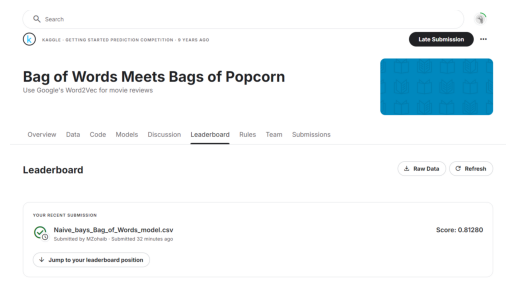

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/Kaggle_Submission.PNG') #Replace "image.jpg" with the path of your image
plt.imshow(img)
plt.axis('off')
plt.show()

![Kaggle_Submission.PNG](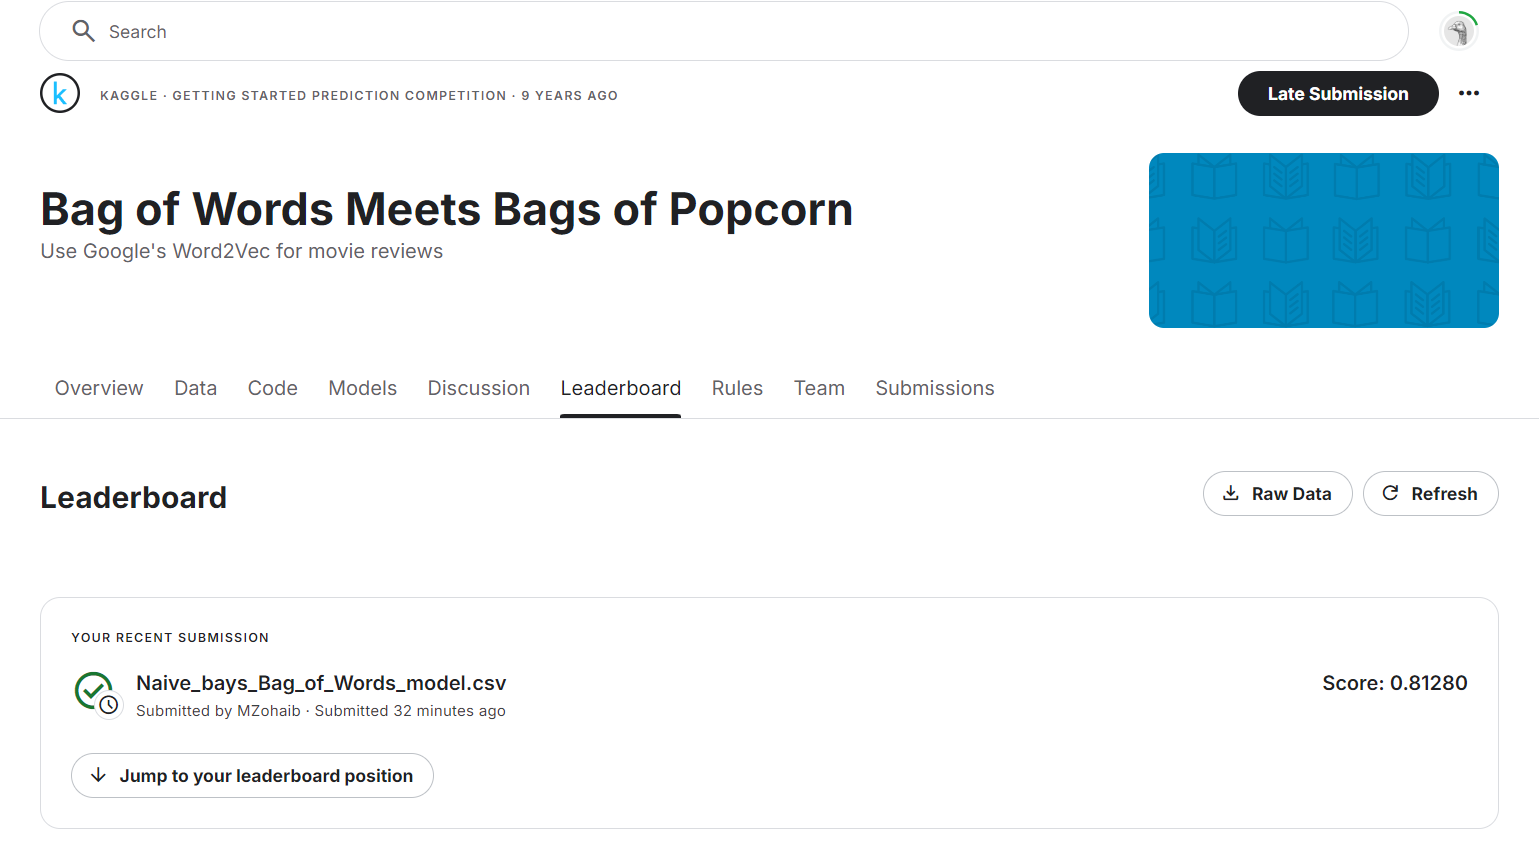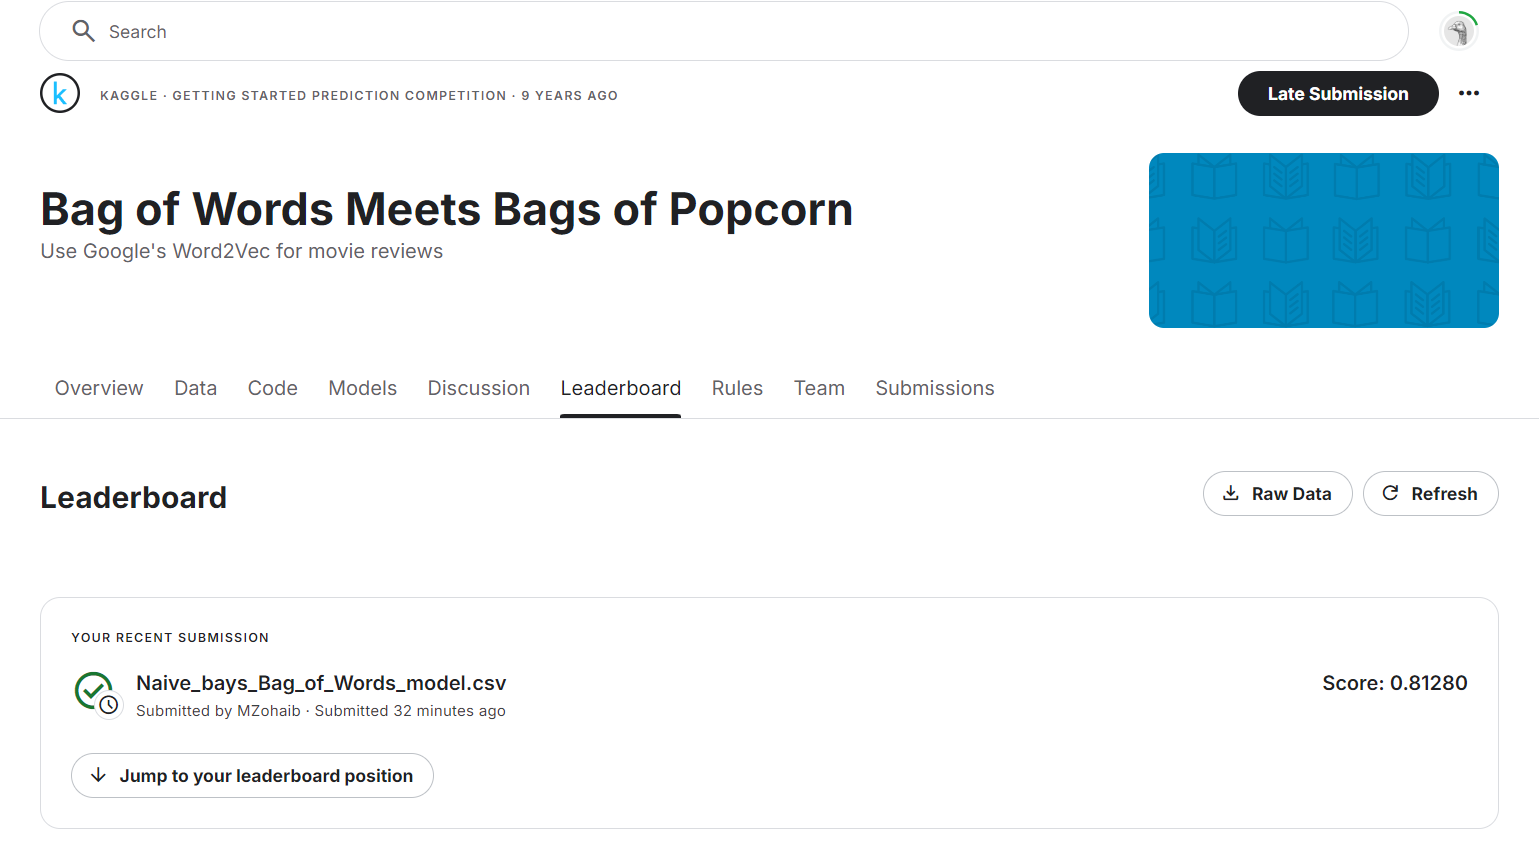)